In [1]:
from pathlib import Path
import sys
sys.path.append('../')
from pma_open import *


#My image
file_path = '../Dropbox Files/hel1.pma'
image_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame.png"
image = io.imread(image_path, as_gray=True)

#Chanel image paths
CH1_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH1.png"
CH2_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH2.png"

good_peaks_1,_ = good_peak_finder(CH1_img_path)
good_peaks_2_new,_ = good_peak_finder(CH2_img_path, sigma=2, block_size=16, scaler_percent=10, boarder=10, max_rad=3)

# Move good_peaks_1 to CH2 to display full image
good_peaks_1_CH2 = shift_peaks(good_peaks_1)
good_peaks_2_CH2 = shift_peaks(good_peaks_2_new)

# Poly Mapping
CH1_peaks_10= np.array([[14, 190], [308, 10], [493, 131], [115, 168], [273, 61], [55, 59], [179, 41], [234, 157], [365, 161], [502, 43]])
CH2_peaks_10 = np.array([[18, 449], [311, 269], [492, 388], [119, 427], [276, 319], [60, 318], [183, 300], [236, 416], [364, 419], [501, 301]])

params_x_man_10, params_y_man_10 = find_polyfit_params(CH1_peaks_10, CH2_peaks_10, degree=3)
mapped_peaks_10 = apply_polyfit_params(good_peaks_1, params_x_man_10, params_y_man_10).astype(np.uint16)
poly_pair_count_tol4_10, poly_pair_arr_CH1_tol4_10, poly_pair_arr_CH2_tol4_10 = find_polyfit_pairs(mapped_peaks_10, good_peaks_1, tolerance=4)


In [2]:
# def draw_circle(radius, y_centre, x_centre, background_dim, colour = [255, 255, 0]):
#     circle_array = np.zeros((background_dim, background_dim, 3), dtype=np.uint8)
#     # Midpoint circle algorithm
#     y = radius
#     x = 0
#     p = 1 - radius
    
#     while y >= x:
#         circle_array[y_centre + y, x_centre + x] = colour
#         circle_array[y_centre - y, x_centre + x] = colour
#         circle_array[y_centre + y, x_centre - x] = colour
#         circle_array[y_centre - y, x_centre - x] = colour
#         circle_array[y_centre + x, x_centre + y] = colour
#         circle_array[y_centre - x, x_centre + y] = colour
#         circle_array[y_centre + x, x_centre - y] = colour
#         circle_array[y_centre - x, x_centre - y] = colour
         
#         x += 1
#         if p <= 0:
#             p = p + 2 * x + 1
#         else:
#             y -= 1
#             p = p + 2 * x - 2 * y + 1
    
#     return circle_array

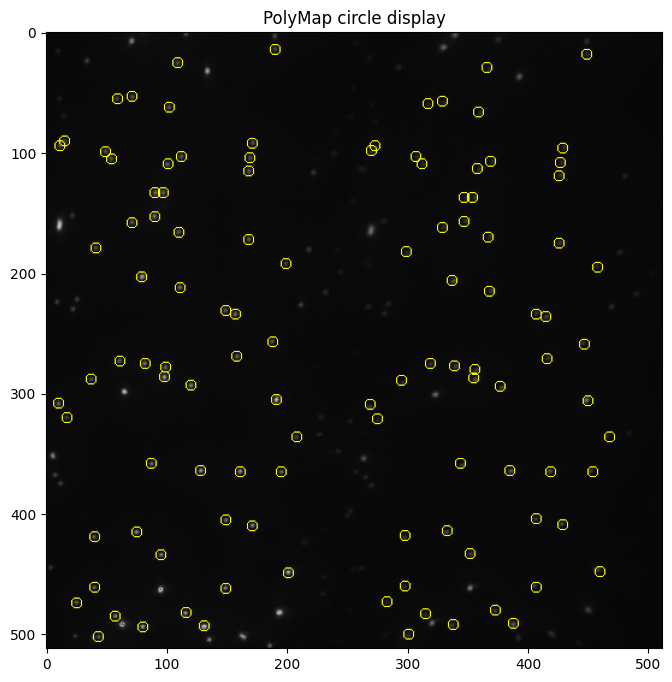

In [3]:
x_centre = np.concatenate((poly_pair_arr_CH1_tol4_10[:,1], poly_pair_arr_CH2_tol4_10[:,1]))
y_centre = np.concatenate((poly_pair_arr_CH1_tol4_10[:,0], poly_pair_arr_CH2_tol4_10[:,0]))
circle_array_new = draw_circle(4, y_centre, x_centre, image.shape[0])

mask_new = (circle_array_new == [255, 255, 0]).all(axis=-1)
if image.ndim == 2:
    image_3d = np.repeat(image[..., np.newaxis], 3, -1)
elif image.ndim==3 and image.shape[2]==3:
    image_3d = image
image_3d[mask_new] = [255, 255, 0]

fig = plt.figure(figsize=(8,8))
ax = fig.subplots()
plt.imshow(image_3d)
plt.title('PolyMap circle display')
plt.show()

# First peak in CH1 [493, 131], corresponding CH2 peak is [491 388]

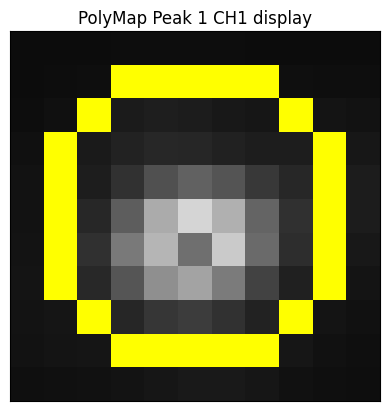

In [4]:
# fig = plt.figure(figsize=(8,8))
# ax = fig.subplots()
plt.imshow(image_3d[488:499,126:137])
plt.xticks([])
plt.yticks([])
plt.title('PolyMap Peak 1 CH1 display')
plt.show()


In [5]:
print(np.arange(488,499))
print(image_3d[490, 129])

[488 489 490 491 492 493 494 495 496 497 498]
[27 27 27]


In [6]:
print(image_3d[490,129])

[27 27 27]


In [7]:
#Demonstates that we are selecting the pixels within the yellow circle outline
def fill_circle(input_array, radius, y_centre, x_centre, colour_fill = [255, 255, 255]):
    #filling in the circle
    for j in range(x_centre - radius, x_centre + radius + 1):
        for i in range(y_centre - radius, y_centre + radius + 1):
            if (j - x_centre) ** 2 + (i - y_centre) ** 2 < radius ** 2:
                input_array[i, j] = colour_fill
    
    return input_array


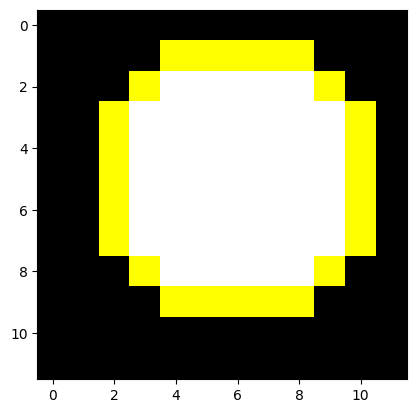

In [8]:
radius = 4
background_dim= 12
y_cen = 5
x_cen = 6

background_array = draw_circle(radius, y_cen, x_cen, background_dim)
circle_array = fill_circle(background_array, radius, y_cen, x_cen)
plt.imshow(circle_array)

In [9]:
# #counts the pixels within the circle (should have 45 if the radius is 4)
# def count_circle(radius, y_centre=12, x_centre=12):
#     total = 0
#     #filling in the circle
#     for i in range(x_centre - radius, x_centre + radius + 1):
#         for j in range(y_centre - radius, y_centre + radius + 1):
#             if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
#                 total +=1
    
#     return total


In [10]:
print(count_circle(radius))

45


In [35]:
def intensity_in_circle(input_array, radius, y_centre, x_centre):
    # x = radius
    # y = 0
    total_intensity = 0
    intensity_arr = []
    #filling in the circle
    for i in range(x_centre - radius, x_centre + radius + 1):
        for j in range(y_centre - radius, y_centre + radius + 1):
            if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                intensity_arr.append(int(input_array[j][i][0]))
                total_intensity += int(input_array[j][i][0])

    return total_intensity, intensity_arr

In [37]:
y_cen, x_cen = 5, 6
total_intensity, intensity_array = intensity_in_circle(background_array, radius, y_cen, x_cen)
print(f"45*255 = {45*255}")
print(f"Calculated total intensity: {total_intensity}")

45*255 = 11475
Calculated total intensity: 11475


# Testing Fill circle with peak 1 CH2 of image_3d [493, 131]

[]

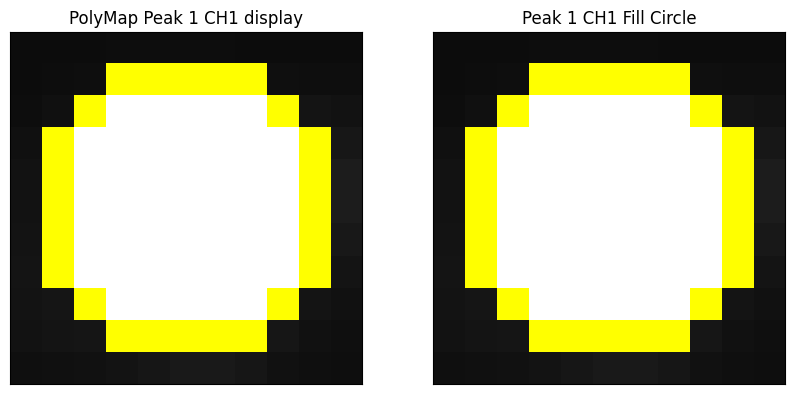

In [38]:
#defining arguments for fill_circle
y_cen = 493-488 #y_centre coord - image y bound
x_cen = 131-126 #x_centre coord - image x bound
radius = 4
image = image_3d[488:499,126:137]

#plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image)
ax[0].set_title('PolyMap Peak 1 CH1 display')
ax[0].set_xticks([])
ax[0].set_yticks([])

filled_peak1_array = fill_circle(image, radius, y_cen, x_cen)
ax[1].imshow(filled_peak1_array)
ax[1].set_title('Peak 1 CH1 Fill Circle')
ax[1].set_xticks([])
ax[1].set_yticks([])

#### We can see that fill_circle works well for a single peak!
# Now try for CH1 peaks

In [39]:
print(poly_pair_arr_CH1_tol4_10[:,0])



[493 305 494 449 286 364 203 365 415 482 485 410 462 434 293 275 153 405
 212 358 234 278 365 133 461 133 308 419 269 273 109 172 474 231 502 115
 166 103 158  62 257 105  99  94 179  25  92  53 104 288  14 320  55  90
 192 336]


In [40]:
def fill_circle_arr(input_array, radius, y_centre, x_centre, colour_fill = [255, 255, 255]):
    # x = radius
    # y = 0
    input_array_1 = input_array.copy()
    
    # Iterate over all centers since we cannont pass original fill_circle function two arrays
    for yc, xc in zip(y_centre, x_centre):
        for i in range(xc - radius, xc + radius + 1):
            for j in range(yc - radius, yc + radius + 1):
                if (i - xc) ** 2 + (j - yc) ** 2 < radius ** 2:
                    input_array_1[j][i] = colour_fill

    return input_array_1

[]

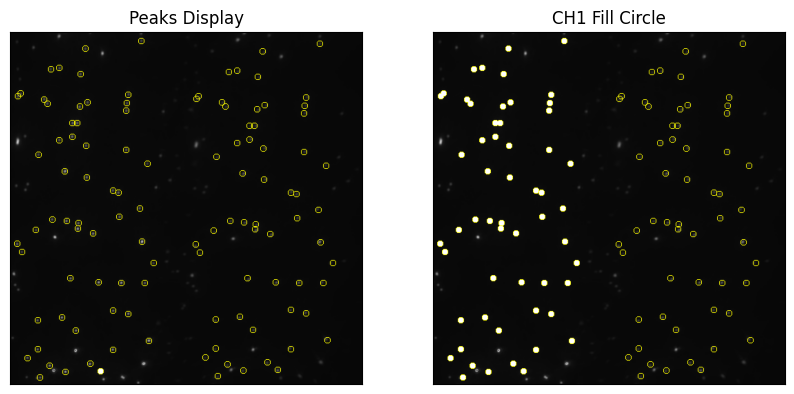

In [16]:
#plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image_3d)
ax[0].set_title('Peaks Display')
ax[0].set_xticks([])
ax[0].set_yticks([])

#y_cen = poly_pair_arr_CH1_tol4_10[:,0]
#x_cen = poly_pair_arr_CH1_tol4_10[:,0]
filled_CH1 = fill_circle_arr(image_3d, 4, poly_pair_arr_CH1_tol4_10[:,0], poly_pair_arr_CH1_tol4_10[:,1])
ax[1].imshow(filled_CH1)
ax[1].set_title('CH1 Fill Circle')
ax[1].set_xticks([])
ax[1].set_yticks([])

[]

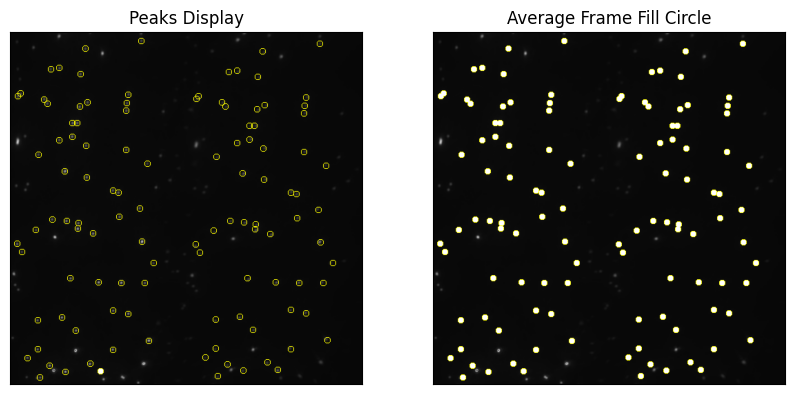

In [17]:
y_coord_centres = np.concatenate((poly_pair_arr_CH1_tol4_10[:,0], poly_pair_arr_CH2_tol4_10[:,0]))
x_coord_centres = np.concatenate((poly_pair_arr_CH1_tol4_10[:,1], poly_pair_arr_CH2_tol4_10[:,1]))

#plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image_3d)
ax[0].set_title('Peaks Display')
ax[0].set_xticks([])
ax[0].set_yticks([])

filled_CH1 = fill_circle_arr(image_3d, 4, y_coord_centres, x_coord_centres)
ax[1].imshow(filled_CH1)
ax[1].set_title('Average Frame Fill Circle')
ax[1].set_xticks([])
ax[1].set_yticks([])

#### Now I know that we are selecting the correct pixels !!
# Test that counting pixels function works correctly we should be finding 45*56

In [18]:
# def sgl_frame_intense_arr(input_array, radius, y_centre_arr, x_centre_arr):
#     x = radius
#     y = 0

#     intensity_arr_all_peaks = []
#     total_arr = []

#     #filling in the circle
#     for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
#         total = 0
#         for i in range(x_centre - radius, x_centre+ radius + 1):
#             for j in range(y_centre - radius, y_centre + radius + 1):
#                 if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
#                     intensity_arr_all_peaks.append(input_array[i][j][0])
#                     total += int(input_array[i][j][0])
#         total_arr.append(total)

#     return intensity_arr_all_peaks, total_arr

In [19]:
intensity_arr_CH1, total_intensity_arr_CH1 = sgl_frame_intense_arr(image_3d, 4, poly_pair_arr_CH1_tol4_10[:,0], poly_pair_arr_CH1_tol4_10[:,1])
print(f"Length of intensity_arr_CH1: {len(intensity_arr_CH1)}")
print(f"45*56 = {45*56}")

print(f"\nTotal Arr Length: {len(total_intensity_arr_CH1)}")


# This tells us that within intensity_arr_CH1, groups of 45 pixels describe a single peak

Length of intensity_arr_CH1: 2520
45*56 = 2520

Total Arr Length: 56


In [20]:
intensity_arr, total_intensity_arr = sgl_frame_intense_arr(image_3d, 4, y_coord_centres, x_coord_centres)
print(f"Length of intensity_arr: {len(intensity_arr)}")
print(f"45*56*2 = {45*112}")

print(f"\nTotal Arr Length: {len(total_intensity_arr)}")

Length of intensity_arr: 5040
45*56*2 = 5040

Total Arr Length: 112


# Correcting for treatment of overlapping circles!
# We only want to be considering the pixel values of the pixels inside the circle and they should not be equal to yellow!

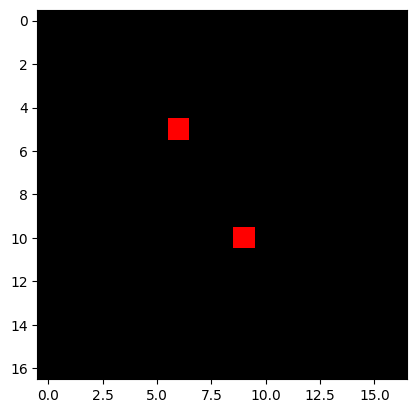

In [21]:
# go to define a function that fills a circle 
radius = 4
background_dim= 17
x_cen = np.array([6, 9])
y_cen = np.array([5, 10])
background = np.zeros((background_dim, background_dim, 3), dtype=np.uint8)
background[5,6] = [255,0,0]
background[10, 9] = [255,0,0]
plt.imshow(background)

Text(0.5, 1.0, 'Circles with Centres in Red')

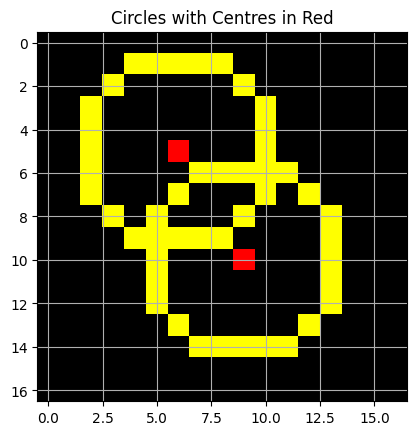

In [22]:
circle_array = draw_circle(radius, y_cen, x_cen, background_dim)
identified_peak_array = circle_array+ background
plt.imshow(identified_peak_array)
plt.grid()
plt.title("Circles with Centres in Red")

# Now I want to replicate peaks!

Text(0.5, 1.0, 'Circles with Centres in Red')

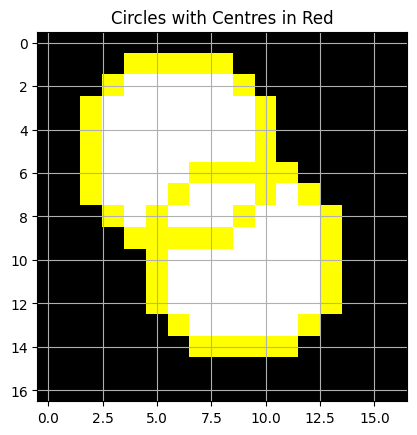

In [23]:
background[2:9, 3:10] = [255,255,255]
background[7:14,6:13] = [255,255,255]

# apply a mask to background

mask = (circle_array == [255, 255, 0]).all(axis=-1)
if background.ndim == 2:
    background_copy = background.copy()
    background_w_mask = np.repeat(background_copy[..., np.newaxis], 3, -1)
elif background.ndim==3 and background.shape[2]==3:
    background_w_mask = background.copy()
background_w_mask[mask] = [255, 255, 0]

plt.imshow(background_w_mask)
plt.grid()
plt.title("Circles with Centres in Red")

#### Above resembles the sort of image we have experimentally!
#### We must check if we are calculating the peak intensitites correctly

In [24]:
intensity_arr, total_intensity_arr = sgl_frame_intense_arr(background_w_mask, 4, y_cen, x_cen)
print(f"Length of intensity_arr: {len(intensity_arr)}")
print(intensity_arr)
print(total_intensity_arr)
print(f"Expected total_intensity_arr: [45*255, 45*255] = [{45*255}, {45*255}]")
print(f"We are missing values because of this overlap and we are counting the yellow pixels !")

Length of intensity_arr: 90
[np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(0), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(0), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(0), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(0), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(0), np.uint8(255), np.uint8(255), np.uint8(0), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(0), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(0), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(0),

In [25]:
# We need to fix this sgl_frame_intense_arr function to account for this overlap
def sgl_frame_intense_arr_new(input_array_wo_mask, radius, y_centre_arr, x_centre_arr):
    # x = radius
    # y = 0

    intensity_arr_all_peaks = []
    total_arr = []

    #filling in the circle
    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        total = 0
        for i in range(x_centre - radius, x_centre+ radius + 1):
            for j in range(y_centre - radius, y_centre + radius + 1):
                if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                    intensity_arr_all_peaks.append(input_array_wo_mask[j][i][2])
                    total += int(input_array_wo_mask[j][i][2])
        total_arr.append(total)

    return intensity_arr_all_peaks, total_arr

In [26]:
intensity_arr_new, total_intensity_arr_new = sgl_frame_intense_arr_new(background, 4, y_cen, x_cen)
print(f"Length of intensity_arr: {len(intensity_arr_new)}")
print(intensity_arr_new)
print(total_intensity_arr_new)
print(f"Expected total_intensity_arr: [45*255, 45*255] = [{45*255}, {45*255}]")
print(f"We are missing values because of this overlap and we are counting the yellow pixels !")

Length of intensity_arr: 90
[np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(255), np.uint8(25

In [27]:
def intensity_in_circle(input_array, radius, y_centre, x_centre):
    total_intensity = 0
    intensity_arr = []
    #filling in the circle
    for i in range(x_centre - radius, x_centre + radius + 1):
        for j in range(y_centre - radius, y_centre + radius + 1):
            if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                intensity_arr.append(int(input_array[j][i][2]))
                total_intensity += int(input_array[j][i][2])

    return total_intensity, intensity_arr

In [28]:
y_cen, x_cen = 5, 6
total_intensity_new, internsity_arr_new = intensity_in_circle(background, radius, y_cen, x_cen)
print(total_intensity_new)
print(internsity_arr_new)
# This code is correct !

11475
[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]


# Fixing intensity_in_circle within the interactive plots!

In [48]:
image = io.imread(image_path, as_gray=True)
Frames_data = read_pma(file_path)

#Give example selected peak coordinates
y_CH1, x_CH1 = poly_pair_arr_CH1_tol4_10[:,0][0], poly_pair_arr_CH1_tol4_10[:,1][0]
y_CH2, x_CH2 = poly_pair_arr_CH2_tol4_10[:,0][0], poly_pair_arr_CH2_tol4_10[:,1][0]

x_centre = np.concatenate((poly_pair_arr_CH1_tol4_10[:,1], poly_pair_arr_CH2_tol4_10[:,1]))
y_centre = np.concatenate((poly_pair_arr_CH1_tol4_10[:,0], poly_pair_arr_CH2_tol4_10[:,0]))

circle_array_new = draw_circle(4, y_centre, x_centre, image.shape[0])

tot_intensity_all_frames_CH1 = []
tot_intensity_all_frames_CH2 = []


for i in range(len(Frames_data)): #for i in range(795): i= 0, 1, 2,..., 794

    mask = (circle_array_new == [255, 255, 0]).all(axis=-1)
    # transforms from 2D to 3D
    if Frames_data[i].ndim == 2:
        frame_data_3d = Frames_data[i].copy()
        frame_data_3d = np.repeat(Frames_data[i][..., np.newaxis], 3, -1)
    elif Frames_data[i].ndim==3 and Frames_data[i].shape[2]==3:
        fframe_data_3d = Frames_data[i].copy()
    frame_data_copy = frame_data_3d.copy()
    frame_data_copy[mask] = [255, 255, 0]

    total_intensity_CH1,_ = intensity_in_circle(frame_data_3d, radius, y_CH1, x_CH1)
    total_intensity_CH2,_ = intensity_in_circle(frame_data_3d, radius, y_CH2, x_CH2)
    tot_intensity_all_frames_CH1.append(total_intensity_CH1)
    tot_intensity_all_frames_CH2.append(total_intensity_CH2)
                

Image Size: 512 x 512


/var/folders/r0/qp6_p2111v1dzb0fg2bbfqsr0000gn/T/ipykernel_82288/1238559163.py:9: RuntimeWarning: overflow encountered in scalar subtract
  if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:


In [49]:
tpf = 1/100
time = np.arange(0, len(tot_intensity_all_frames_CH1)*tpf, tpf)
print(len(tot_intensity_all_frames_CH1))
print(len(time))

795
795
